## **Introduction to Graph Representation Learning**
- One of the goals of representation learning is to output features that make the patterns more obvious for the model to learn from. 
- Graph representation learning involves finding embeddings for every node of the graph so that vital information about the graph structure and information relevant to the inference problem can be captured in the embedding space. 
- Graph representation learning approaches can be categorised into two categories: 
1. Shallow encodings estimate only the firlds of the node embeddings. 
2. Deep encodings estimate more parameters alongside the fields of the node embeddings. 
- The two algorithms mentioned below (DeepWalk and Node2Vec) are examples of shallow encoding. 
- There are three distinct steps involved in graph representation learning: 
1. Finding a local subgraph given a node in the field. A local subgraph can be a graph containing all nodes that are directly connected to an edge of the concerned node, or it can be the set of nodes that have a first and second degree connection to the concerned node. 
2. Takes input from the concerned node and the local subgraph and output the node embedding. 
3. Define a learning objective that emulates what the learned node embeddings need to be optimized for. 

## **DeepWalk**
To introduce DeepWalk, we first introduce the concept of skip-gram. 
#### **The Skip-Gram Model**
- A continuous bag-of-words model is trained to predict a word using its surrounding context (words coming before and after the target word). A continuous skip-gram model feeds a single word to the model and predicts the words around it. 
- In general, the CBOW model is faster to train but the skip-gram model is more accurate due to its ability to learn infrequent words. 

<img src = "images/Screenshot 2025-01-20 at 19.31.29.png" width = "500px">

- Skip-grams are implemented as pairs of words (target word, context word), where `target word` is the input and `context word` is the word to predict. The number of skip-grams for the same target word depends on a parameter called the `context size`.

<img src = "images/Screenshot 2025-01-20 at 19.37.53.png" width = "500px">

In [2]:
import numpy as np
np.random.seed(0)

CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()

# Create skipgrams
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:2])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


- Imagine a sequence of $N$ words $w_1, w_2, \cdots, w_N$. The goal is to maximize the sum of every probability of seeing a context word given a target word in the entire text $$\frac{1}{N} \sum_{n=1}^{N} \sum_{-c \leq j \leq c, j \neq 0} log (p(w_{n+j} | w_n))$$
- The skip-gram model is composed of two layers: 
1. A projection layer with a weight matrix $W_{embed}$, which takes a one-hot encoded word vector as an input and returns the corresponding $N$-dim word embedding. It acts as a lookup table that stores embeddings of a predefined dimensionality. 

$$h = W_{embed}^T * x$$

2. A fully connected layer with a weight matrix $W_{output}$, which takes a word embedding as input and outputs $|V|$-dim logits. A softmax function is applied to these predictions to transform logits into probabilities. 

$$p(w_c|w_t) = \frac{exp(w_{output} * h)}{\sum_{i=1}^{|V|} exp(W_{output_{(i)}} * h)}$$

$$word2vec(w_t) = [p(w_1|w_t) , p(w_2|w_t), \cdots, p(w_{|V|}|w_t)]^T$$

In [6]:
from gensim.models.word2vec import Word2Vec

# Create Word2Vec
model = Word2Vec([text],
                 sg=1,   # Skip-gram
                 vector_size=10,
                 min_count=0,
                 window=2,
                 workers=1,
                 seed=0)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

# Train model
model.train([text], total_examples=model.corpus_count, epochs=10)

# Print a word embedding
print('\nWord embedding =')
print(model.wv[0])

Shape of W_embed: (121, 10)

Word embedding =
[ 0.07156403  0.03257632  0.00209916 -0.04374931 -0.03398107 -0.08656936
 -0.09047253 -0.09552431 -0.06482638  0.0660186 ]


- The computational cost of applying a full softmax function to millions of words is too costly. 
- Instead of a flat softmax that directly calculates the probability of every word, H-softmax uses a binary tree structure where leaves are words. H-softmax can be activated in `gensim` using `hs = 1`.

#### **Random Walks**
- Random walks are a sequences of nodes produced by randomly choosing a neighboring node at every step. 

/Users/kelvinfoo/Library/Python/3.9/lib/python/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


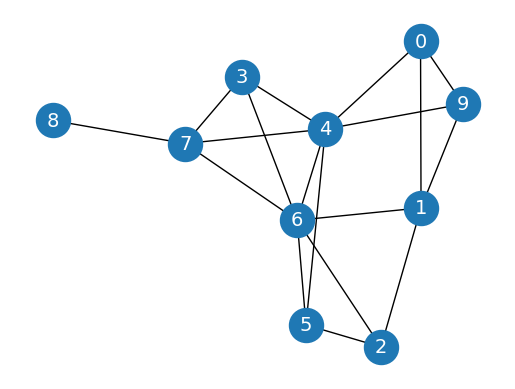

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [8]:
import random
random.seed(0)

def random_walk(start, length):
    walk = [str(start)]  # starting node
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    
    return walk

# Create a list of random walks
print(random_walk(0, 10))

['0', '1', '9', '1', '0', '4', '6', '7', '6', '5', '6']


#### **Implementing DeepWalk**


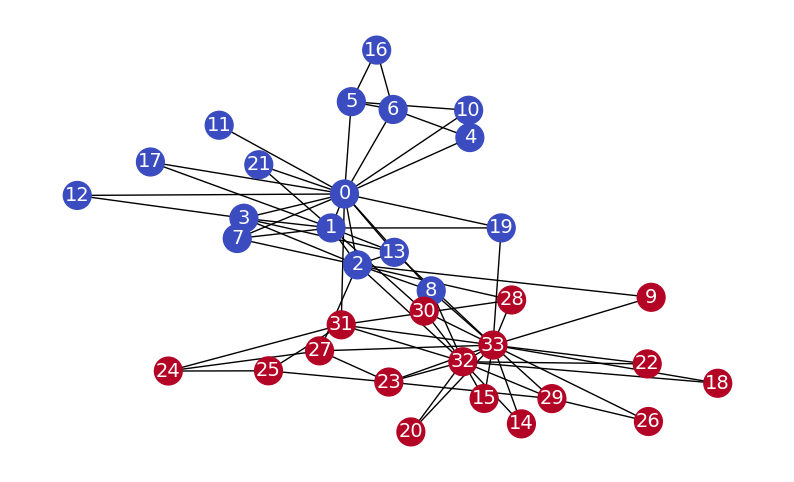

In [12]:
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(10,6))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=400,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [13]:
# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

# Create Word2Vec
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

Shape of embedding matrix: (34, 100)


(186095, 897600)

In [14]:
# Most similar nodes
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

Nodes that are the most similar to node 0:
   ('7', 0.6418750882148743)
   ('11', 0.6362574696540833)
   ('10', 0.6352985501289368)
   ('4', 0.6283851265907288)
   ('1', 0.624032199382782)
   ('17', 0.6081531047821045)
   ('6', 0.5763437151908875)
   ('5', 0.5598757266998291)
   ('21', 0.557222843170166)
   ('16', 0.5503911972045898)


## **Node2Vec**
- The difference between DeepWalk and Node2Vec is that instead of obtaining sequences of nodes with a uniform distribution, the random walks are biased in Node2Vec. 

#### **Building a Neighborhood**

<img src = "images/Screenshot 2025-01-20 at 20.11.32.png" width = "500 px">

- When exploring nodes in the neighborhood of node A, a breadth-first search approach considers the three closest nodes in terms of connections, $N(A) = \{B,C,D\}$. A depth-first search approach consist of selecting nodes that are not adjacent to adjacent nodes first, $N(A) = \{D,E,F\}$. 
- BFS focuses on the local network around a node while DFS establishes a more macro view of the network. 
- Suppose that the current node is `j`, the previous node is `i` and the future node is `k`. $\pi_{jk}$ is the unnormalized transition probability from node `j` to node `k`. 
$$\pi_{jk}  = \alpha(i,k) * w_{jk}$$ 
where $\alpha(i,k)$ is the search bias between modes `i` and `k` and $w_{jk}$ is the weight of the edge from `j` to `k`.
- In DeepWalk, $\alpha(a,b) = 1$ for any pair of nodes. In Node2Vec, $\alpha(a,b)$ is defined based on the distance between the nodes and two additional parameters: the return parameter `p` and the in-out parameter `q`. Their role is to approximate DFS and BFS respectively. 

$$\alpha (a,b) = \begin{cases} 
    \frac{1}{p}, d_{ab} = -1 \\ 
    1, d_{ab} = 1 \\ 
    \frac{1}{q}, d_{ab} = 2 \end{cases}$$

<img src = "images/Screenshot 2025-01-20 at 20.23.01.png" width = "500 px" >

- Supose the walk starts from node `i` and now arrives at node `j`. The probability of going back to `i` is controlled by the parameter `p`. The higher `p` is, the more the random walk will explore new nodes instead of repeating the same ones and looking like DFS. 
- The probability of going to $k_1$ is 1 because the node is in the immediate neighborhood of the previous node.
- The probability of going to $k_2$ is controlled by the parameter `q`. The higher it is, the more the random walk will focus on nodes that are close to the previous ones and look like BFS. 

In [15]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))
    
    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

In [16]:
random_walk(0, 8, p = 10, q = 1)

[0, 9, 1, 2, 6, 3, 7, 8, 7]

Note that the random walk never goes back to the previous node because `p` is high. 

In [17]:
random_walk(0, 8, p = 1, q = 10)

[0, 1, 9, 1, 0, 1, 9, 1, 0]

Note that since `q` is high, the random walk keeps going back to the previous node. 

#### **Implementing Node2Vec**

In [18]:
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

(186450, 897600)